# CIRCUTOR DATA ANALYSIS
### Analizador de data en Google Colab, escrito en Python para hacer un análisis rápido de la data cruda del Circutor MYeBOX 150

Realizado por: Ing. Jorge Fadul - Corporación Tesla S.A.

Dependencias:

In [ ]:
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

Elegir data desde Entorno de Colab (más rápido, requiere cambiar la línea 2 por el nombre del archivo csv)

```
# df = pd.read_csv("NOMBRE_ARCHIVO.csv", encoding="latin-1")
```





In [ ]:
def cargar_datos(nombre_archivo=None, encoding='latin-1'):
    """
    Intenta cargar un archivo CSV por nombre. Si no lo encuentra, permite subir uno manualmente.

    Args:
        nombre_archivo (str): Nombre del archivo a buscar por defecto.
        encoding (str): Codificación del archivo CSV.

    Returns:
        pd.DataFrame: DataFrame con los datos cargados, o None si falla.
    """

    if nombre_archivo:

        try:
            df = pd.read_csv(nombre_archivo, encoding=encoding)
            print(f"Archivo '{nombre_archivo}' cargado exitosamente:")
            display(df.head())
            # display(df.tail())
            return df

        except FileNotFoundError:
            print(f"No se encontró el archivo '{nombre_archivo}'. Selecciona uno manualmente:")

            try:
                uploaded = files.upload()
                filename = next(iter(uploaded))
                df = pd.read_csv(filename, encoding=encoding)
                print("Archivo cargado exitosamente:")
                display(df.head())
                return df

            except pd.errors.ParserError:
                print("Error al analizar el archivo CSV. Verifica su formato.")
            except UnicodeDecodeError:
                print("Error de codificación. Intenta con otro encoding.")
            except Exception as e:
                print(f"Ocurrió un error al cargar el archivo: {e}")

        except Exception as e:
            print(f"Ocurrió un error al intentar cargar '{nombre_archivo}': {e}")

    return None

# df_cargado = cargar_datos("cmsjb_2.csv")

Divide el Dataframe entre data eléctrica (df) y data de armónicos (df_arm)

In [ ]:
def dividir_dataframe(df, ver_df: bool = False):
    try:

        # Crear df_arm con columnas que empiezan por 'Arm.' o contienen 'Fund.'
        mask = df.columns.str.startswith('Arm.') | df.columns.str.contains('Fund.') | df.columns.str.contains('Fecha/hora')

        df_arm = df.loc[:, mask].copy()

        # Eliminar del df original las columnas que empiezan por 'Arm.', contienen 'Fund.', 'mín' o 'máx'
        drop_mask = (
            df.columns.str.startswith('Arm.') |
            df.columns.str.contains('Fund.') |
            df.columns.str.contains('mín', case=False) |
            df.columns.str.contains('máx', case=False)
        )
        df = df.drop(columns=df.columns[drop_mask])

        if ver_df:

            # Imprimir las columnas de df_arm
            print("\nColumnas del DataFrame df_arm:")
            for col in df_arm.columns:
                print(col)

            # Imprimir las columnas del df restante
            print("\nColumnas restantes del DataFrame df:")
            for col in df.columns:
                print(col)

        return df, df_arm


    except NameError:
        print("Asegúrate de haber cargado los DataFrames antes de modificarlos.")
    except Exception as e:
        print(f"Ocurrió un error al combinar los DataFrames: {e}")


# df, df_arm = dividir_dataframe(df_cargado)


Sub-división del Dataframe en tipos de parámetros eléctricos:

In [ ]:
def sub_dividir_dataframe(df, ver_cols: bool = False):
        # Definimos funciones para seleccionar columnas con patrones comunes
        def select_cols(df, patterns):
            return [col for col in df.columns if any(pat in col for pat in patterns)]

        # Crear cada DataFrame por categoría


        # 2. Potencias
        pactiva_cols = [col for col in df.columns if 'P.Activa' in col]
        pcapacitiva_cols = [col for col in df.columns if 'P.Capacitiva' in col]
        pinductiva_cols = [col for col in df.columns if 'P.Inductiva' in col]
        df["P.Activa III T"] = df["P.Activa III"] - df["P.Activa III -"]
        df["P.Inductiva III T"] = df["P.Inductiva III"] - df["P.Inductiva III -"]
        df["P.Capacitiva III T"] = df["P.Capacitiva III"] - df["P.Capacitiva III -"]
        df["P.Reactiva III T"] = (df["P.Inductiva III T"] + df["P.Capacitiva III T"])
        df["P.Aparente III T"] = np.sqrt(df["P.Activa III T"]**2 + df["P.Reactiva III T"]**2)
        df_potencia = df[pactiva_cols + pcapacitiva_cols + pinductiva_cols + ["P.Activa III T","P.Inductiva III T", "P.Capacitiva III T","P.Reactiva III T","P.Aparente III T"]]

        # Add new columns for energy
        df["E.Activa III T"] = df["P.Activa III T"] * (1/60)
        df["E.Reactiva III T"] = df["P.Reactiva III T"] * (1/60)
        df["E.Reactiva III M"] = df["P.Inductiva III T"] * (1/60)
        df["E.Inductiva III T"] = df["P.Inductiva III"] * (1/60)
        df["E.Reactiva III M2"] = (df["P.Inductiva III"] + df["P.Capacitiva III -"]) * (1/60)
        df["E.Aparente III T"] = df["P.Aparente III T"] * (1/60)



        # 1. General
        tension_cols = select_cols(df, ['Tensión III', 'Tensión L1', 'Tensión L2', 'Tensión L3', 'Tensión L12', 'Tensión L23', 'Tensión L31', 'Tensión L1L2L3', 'Tensión de neutro'])
        corriente_cols = select_cols(df, ['Corriente III', 'Corriente L1', 'Corriente L2', 'Corriente L3', 'Corriente de neutro'])
        cosphi_cols = [col for col in df.columns if 'Cos Phi' in col]
        fp_cols = [col for col in df.columns if 'F.P.' in col and ('III' in col or 'L1' in col or 'L2' in col or 'L3' in col)]
        df["F.P. III T"] = df["F.P. III"] + df["F.P. III -"]
        df["Cos Phi III T"] = df["Cos Phi III"] + df["Cos Phi III -"]
        df["P/S"] = np.where(df["P.Aparente III T"] == 0, 0, df["P.Activa III T"] / df["P.Aparente III T"])
        df_general = df[tension_cols + corriente_cols + ['Frecuencia', "F.P. III T", "Cos Phi III T", "P/S"] + fp_cols + cosphi_cols]

        # 3. Fasores
        fasores_cols = [col for col in df.columns if 'Fasores' in col]
        df_fasor = df[fasores_cols]

        # 4. Energía
        eactiva_cols = [col for col in df.columns if 'E.Activa' in col]
        ecapacitiva_cols = [col for col in df.columns if 'E.Capacitiva' in col]
        einductiva_cols = [col for col in df.columns if 'E.Inductiva' in col]
        eaparente_cols = [col for col in df.columns if 'E.Aparente' in col]
        df_energia = df[eactiva_cols + ecapacitiva_cols + einductiva_cols + eaparente_cols]

        # 5. Coste
        coste_cols = [col for col in df.columns if 'Coste' in col]
        df_coste = df[coste_cols]

        # 6. Secundarias
        vc_directa = [col for col in df.columns if 'directa' in col]
        vc_homopolar = [col for col in df.columns if 'homopolar' in col]
        vc_inversa = [col for col in df.columns if 'inversa' in col]
        factor_crest = [col for col in df.columns if 'Factor cresta' in col]
        thd_cols = [col for col in df.columns if 'THD/d' in col]
        dist_corriente = [col for col in df.columns if 'Distorsión en corriente' in col]
        dist_tension = [col for col in df.columns if 'Distorsión en tensión' in col]
        ka_kd_k = [col for col in df.columns if any(k in col for k in ['Ka A', 'Ka V', 'Kd A', 'Kd V', 'Factor K'])]
        df_secundario = df[vc_directa + vc_homopolar + vc_inversa + factor_crest + thd_cols + dist_corriente + dist_tension + ka_kd_k]


        if ver_cols:

            print("\nEncabezados df_general:")
            for col in df_general.columns:
                print(col)

            print("\nEncabezados df_potencias:")
            for col in df_potencia.columns:
                print(col)

            print("\nEncabezados df_fasores:")
            for col in df_fasor.columns:
                print(col)

            print("\nEncabezados df_energia:")
            for col in df_energia.columns:
                print(col)

            print("\nEncabezados df_coste:")
            for col in df_coste.columns:
                print(col)

            print("\nEncabezados df_secundarias:")
            for col in df_secundario.columns:
                print(col)

        return df_general, df_potencia, df_fasor, df_energia, df_coste, df_secundario

# df_general, df_potencia, df_fasor, df_energia, df_coste, df_secundario = sub_dividir_dataframe(df)

In [ ]:
def promediar_df_por_min(df, dias_semana=None):
    """
    Calcula el promedio de cada columna numérica para cada minuto del día,
    con opción de filtrar por días específicos de la semana.
    El índice resultante 'Fecha/hora' tendrá la fecha ficticia 1900-01-01.

    Args:
        df (pd.DataFrame): DataFrame con columna 'Fecha/hora' en formato datetime.
        dias_semana (list, optional): Lista de días en español (ej. ['lunes', 'martes']).
                                      Si None, usa todos los días.

    Returns:
        pd.DataFrame: DataFrame con promedio para cada minuto del día
                      con índice 'Fecha/hora' (1000-01-01 HH:MM).
    """
    # Copia para no modificar el original
    df_copy = df.copy()

    # Asegurar datetime
    df_copy['Fecha/hora'] = pd.to_datetime(df_copy['Fecha/hora'])

    # Crear columna de nombre de día en inglés
    df_copy['day_name_en'] = df_copy['Fecha/hora'].dt.day_name()

    # Mapeo de días inglés -> español
    day_map = {
        'Monday': 'lunes',
        'Tuesday': 'martes',
        'Wednesday': 'miércoles',
        'Thursday': 'jueves',
        'Friday': 'viernes',
        'Saturday': 'sábado',
        'Sunday': 'domingo'
    }
    df_copy['dia_nombre'] = df_copy['day_name_en'].map(day_map)

    # Filtrar por días si se indica
    if dias_semana:
        dias_semana = [d.lower() for d in dias_semana]
        df_copy = df_copy[df_copy['dia_nombre'].isin(dias_semana)]

    # Extraer hora y minuto y asignarle directamente la fecha ficticia 1000-01-01
    df_copy['Fecha/hora'] = pd.to_datetime(
        '1900-01-01 ' + df_copy['Fecha/hora'].dt.strftime('%H:%M'),
        format='%Y-%m-%d %H:%M'
    )

    # Promediar columnas numéricas por cada minuto del día
    numeric_cols = df_copy.select_dtypes(include=np.number).columns.tolist()
    df_promedio = df_copy.groupby('Fecha/hora')[numeric_cols].mean().sort_index()

    return df_promedio


Función de Graficación de resultados:





In [ ]:
def graficar_parametros(df, parametros,
                         fecha_inicio=None, fecha_fin=None,
                         hora_inicio='00:00', hora_fin='23:59',
                         limite_inferior=None, limite_superior=None,
                         lineas_verticales=None, lineas_horizontales=None,
                         titulo="Parámetros vs Tiempo"):
    """
    Grafica parámetros de un DataFrame con soporte para:
        - líneas horizontales/verticales con color
        - color y estilo de línea por parámetro

    Formatos válidos en 'parametros':
        ["PARAM1", "PARAM2"]
        [("PARAM1", "red")]
        [("PARAM1", "red", "--")]
    """
    try:
        if not parametros or not isinstance(parametros, list):
            raise ValueError("Debes proporcionar una lista no vacía de parámetros")

        plt.figure(figsize=(14, 7))

        es_promedio = False

        # Conversión de fechas
        if 'Fecha/hora' in df.columns:
            df['FechaHora'] = pd.to_datetime(df['Fecha/hora'], dayfirst=True, errors='coerce')
            df_filtrado = df.dropna(subset=['FechaHora']).set_index('FechaHora')
        elif 'Fecha' in df.columns and 'Hora' in df.columns:
            df['FechaHora'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora'], dayfirst=True, errors='coerce')
            df_filtrado = df.dropna(subset=['FechaHora']).set_index('FechaHora')
        else:
            df_filtrado = df.copy()
            if isinstance(df_filtrado.index, pd.DatetimeIndex):
                if (df_filtrado.index.date == pd.to_datetime("1900-01-01").date()).all():
                    es_promedio = True
            else:
                raise ValueError("No se encontró un índice datetime válido en el DataFrame.")

        def desempaquetar_item(item):
            # Analiza cada elemento de la lista de parámetros
            if isinstance(item, str):
                return item, None, '-'    # nombre, color por defecto, línea normal
            elif isinstance(item, (list, tuple)):
                if len(item) == 1:
                    return item[0], None, '-'
                elif len(item) == 2:
                    return item[0], item[1], '-'
                elif len(item) == 3:
                    return item[0], item[1], item[2]
            raise ValueError(f"Formato no válido en parametros: {item}")

        if es_promedio:
            hora_inicio_dt = pd.to_datetime(hora_inicio, format='%H:%M').time()
            hora_fin_dt = pd.to_datetime(hora_fin, format='%H:%M').time()

            df_filtrado = df_filtrado.between_time(hora_inicio_dt, hora_fin_dt)

            x = df_filtrado.index

            for item in parametros:
                param, color, estilo = desempaquetar_item(item)
                if param not in df_filtrado.columns:
                    raise ValueError(f"El parámetro '{param}' no se encuentra en el DataFrame")
                plt.plot(x, df_filtrado[param], linestyle=estilo, color=color, label=param)

            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
            plt.xlabel('Hora del día')
            titulo = "Parámetros Promedio por Minuto"

        else:
            fecha_inicio_dt = pd.to_datetime(fecha_inicio) if fecha_inicio else df_filtrado.index.min()
            fecha_fin_dt = pd.to_datetime(fecha_fin) if fecha_fin else df_filtrado.index.max()
            hora_inicio_dt = pd.to_datetime(hora_inicio, format='%H:%M').time()
            hora_fin_dt = pd.to_datetime(hora_fin, format='%H:%M').time()

            df_filtrado = df_filtrado[
                (df_filtrado.index.date >= fecha_inicio_dt.date()) &
                (df_filtrado.index.date <= fecha_fin_dt.date()) &
                (df_filtrado.index.time >= hora_inicio_dt) &
                (df_filtrado.index.time <= hora_fin_dt)
            ]

            for item in parametros:
                param, color, estilo = desempaquetar_item(item)
                if param not in df_filtrado.columns:
                    raise ValueError(f"El parámetro '{param}' no se encuentra en el DataFrame")
                plt.plot(df_filtrado.index, df_filtrado[param], linestyle=estilo, color=color, label=param)

            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            plt.xlabel('Fecha y Hora')

            if lineas_verticales:
                for lv in lineas_verticales:
                    if isinstance(lv, (list, tuple)) and len(lv) == 2:
                        fecha_linea, color = lv
                    else:
                        fecha_linea, color = lv, 'black'
                    fecha_linea = pd.to_datetime(fecha_linea)
                    plt.axvline(x=fecha_linea, color=color, linestyle='--')

        if lineas_horizontales:
            for lh in lineas_horizontales:
                if isinstance(lh, (list, tuple)) and len(lh) == 2:
                    valor, color = lh
                else:
                    valor, color = lh, 'red'
                plt.axhline(y=valor, color=color, linestyle='--')

        plt.title(titulo)
        plt.ylabel('Valor')
        plt.legend()
        plt.grid(True)

        if limite_inferior is not None or limite_superior is not None:
            plt.ylim(bottom=limite_inferior, top=limite_superior)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al graficar: {e}")


In [ ]:
def calcular_sumatoria_energia(df, tipo_energia, fecha_inicio=None, fecha_fin=None, hora_inicio='00:00', hora_fin='23:59'):
    """
    Calcula la sumatoria de energía consumida (Activa o Reactiva) y su extrapolación a 30 días,
    incluyendo la división por bloques horarios: punta, fuera punta medio y fuera punta bajo.

    Args:
        df (pd.DataFrame): DataFrame con los datos de energía.
        tipo_energia (str): Tipo de energía ('E.Activa III T' o 'E.Reactiva III T').
        fecha_inicio (str, optional): Fecha de inicio ("AAAA-MM-DD").
        fecha_fin (str, optional): Fecha de fin ("AAAA-MM-DD").
        hora_inicio (str, optional): Hora de inicio ("HH:MM").
        hora_fin (str, optional): Hora de fin ("HH:MM").

    Returns:
        energia_actual_total (float): Energía total medida en el intervalo.
        energia_actual_por_bloque (dict): Energía medida por bloque horario.
        energia_extrapolada_total (float): Energía extrapolada a 30 días.
        energia_extrapolada_por_bloque (dict): Energía extrapolada por bloque horario.
    """
    try:
        # Unificar fecha y hora
        if 'Fecha' in df.columns and 'Hora' in df.columns:
            df['FechaHora'] = pd.to_datetime(df['Fecha'].astype(str) + ' ' + df['Hora'].astype(str), dayfirst=True, errors='coerce')
        elif 'Fecha/hora' in df.columns:
            df['FechaHora'] = pd.to_datetime(df['Fecha/hora'], dayfirst=True, errors='coerce')
        else:
            raise ValueError("No se encontró una columna de fecha y hora válida")

        df = df.dropna(subset=['FechaHora'])

        # Rango de tiempo
        fecha_inicio_dt = pd.to_datetime(fecha_inicio + ' ' + hora_inicio) if fecha_inicio else df['FechaHora'].min()
        fecha_fin_dt = pd.to_datetime(fecha_fin + ' ' + hora_fin) if fecha_fin else df['FechaHora'].max()

        # Filtrar por el intervalo
        df_filtrado = df[(df['FechaHora'] >= fecha_inicio_dt) & (df['FechaHora'] <= fecha_fin_dt)]

        if tipo_energia not in df_filtrado.columns:
            raise ValueError(f"La columna '{tipo_energia}' no se encuentra en el DataFrame.")

        dias_intervalo = (fecha_fin_dt - fecha_inicio_dt).total_seconds() / (60 * 60 * 24)

        # Clasificar por bloque horario
        def clasificar_bloque(fila):
            dt = fila['FechaHora']
            hora = dt.time()
            dia = dt.weekday()  # lunes=0, domingo=6

            if dia < 5:  # Lunes a Viernes
                if pd.to_datetime("09:00").time() <= hora <= pd.to_datetime("17:00").time():
                    return "punta"
                elif pd.to_datetime("17:01").time() <= hora <= pd.to_datetime("23:59").time():
                    return "fuera_punta_medio"
                else:
                    return "fuera_punta_bajo"
            elif dia == 5:  # Sábado
                if pd.to_datetime("11:00").time() <= hora <= pd.to_datetime("22:59").time():
                    return "fuera_punta_medio"
                else:
                    return "fuera_punta_bajo"
            else:  # Domingo
                return "fuera_punta_bajo"

        df_filtrado['bloque'] = df_filtrado.apply(clasificar_bloque, axis=1)

        # Energía actual total
        energia_actual_total = df_filtrado[tipo_energia].sum()

        # Energía actual por bloque
        energia_actual_por_bloque = df_filtrado.groupby('bloque')[tipo_energia].sum().to_dict()

        # Energía extrapolada total
        energia_extrapolada_total = energia_actual_total * 30 / dias_intervalo if dias_intervalo > 0 else float('nan')

        # Energía extrapolada por bloque
        energia_extrapolada_por_bloque = {
            bloque: val * 30 / dias_intervalo for bloque, val in energia_actual_por_bloque.items()
        }

        # Mostrar resultados
        print(f"➡ Energía total actual de {tipo_energia}: {energia_actual_total:.2f} kWh")
        print("➡ Energía actual por bloque:")
        for bloque, val in energia_actual_por_bloque.items():
            print(f"   {bloque}: {val:.2f} kWh")

        print(f"\n➡ Energía extrapolada a 30 días: {energia_extrapolada_total:.2f} kWh")
        print("➡ Energía extrapolada por bloque:")
        for bloque, val in energia_extrapolada_por_bloque.items():
            print(f"   {bloque}: {val:.2f} kWh")

        return energia_actual_total, energia_actual_por_bloque, energia_extrapolada_total, energia_extrapolada_por_bloque

    except Exception as e:
        print(f"Error al calcular la sumatoria de energía: {e}")
        return None, {}, None, {}

# e_act_sum, e_act_bloq, e_ext_sum, e_ext_bloq = calcular_sumatoria_energia(df, 'E.Activa III T')



In [ ]:

def agregar_factor_potencia_mensual(df):
    """
    Agrega al DataFrame:
    - 'F.P. M': Factor de potencia acumulado hasta cada instante.
    - fp_mensual: Valor escalar mensual extrapolado si el intervalo es menor a 30 días.

    Returns:
        df (pd.DataFrame): DataFrame con la columna 'F.P. M'.
        fp_mensual (float): Valor mensual extrapolado o medido completo.
    """
    try:
        df = df.copy()

        # Verificar y convertir fechas
        if 'Fecha' in df.columns and 'Hora' in df.columns:
            df['FechaHora'] = pd.to_datetime(df['Fecha'].astype(str) + ' ' + df['Hora'].astype(str), dayfirst=True, errors='coerce')
        elif 'Fecha/hora' in df.columns:
            df['FechaHora'] = pd.to_datetime(df['Fecha/hora'], dayfirst=True, errors='coerce')
        else:
            raise ValueError("No se encontró una columna de fecha y hora válida")

        df = df.dropna(subset=['FechaHora', 'E.Reactiva III M2', 'E.Activa III T']).sort_values(by='FechaHora').reset_index(drop=True)

        # Calcular acumulados
        acum_kvarh = df['E.Reactiva III M2'].cumsum()
        acum_kwh = df['E.Activa III T'].cumsum()

        # FP acumulado por instante
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = np.where(acum_kwh != 0, acum_kvarh / acum_kwh, np.nan)
            df['F.P. M'] = np.cos(np.arctan(ratio))

        # Intervalo de días
        fecha_inicio = df['FechaHora'].min()
        fecha_fin = df['FechaHora'].max()
        dias_medidos = (fecha_fin - fecha_inicio).total_seconds() / (60 * 60 * 24)

        # Energías medidas
        kvarh_total = df['E.Reactiva III M'].sum(skipna=True)
        kwh_total = df['E.Activa III T'].sum(skipna=True)

        # Extrapolación si es menor a 30 días
        if dias_medidos < 30:
            factor_extrap = 30 / dias_medidos if dias_medidos > 0 else 0
            kvarh_ext = kvarh_total * factor_extrap
            kwh_ext = kwh_total * factor_extrap
            print(f"\nSe extrapolaron los datos de {dias_medidos:.1f} días a 30 días.")
        else:
            kvarh_ext = kvarh_total
            kwh_ext = kwh_total
            print(f"\nNo se requiere extrapolación. Días medidos: {dias_medidos:.1f}")

        # Calcular FP mensual
        if kwh_ext == 0 or math.isnan(kwh_ext) or math.isnan(kvarh_ext):
            print("No se puede calcular el factor de potencia mensual: Energía inválida.")
            fp_mensual = float('nan')
        else:
            fp_mensual = math.cos(math.atan(kvarh_ext / kwh_ext))
            print(f"Factor de Potencia Medido mensual: {fp_mensual:.4f}")

        return df, fp_mensual

    except Exception as e:
        print(f"Error al calcular el Factor de Potencia: {e}")
        return df, float('nan')


# df, fp_mensual = agregar_factor_potencia_mensual(df)


In [ ]:
def procesar_demanda_maxima(df_original):
    """
    Procesa la demanda máxima calculando la media móvil de 15 minutos desplazada
    cada 5 minutos en 5 conjuntos (SDATA1..SDATA5). Aplica la misma lógica tanto
    para datos históricos como para datos promediados (1900-01-01).

    Args:
        df_original (pd.DataFrame): Debe tener columna o índice 'Fecha/hora' y 'P.Activa III'.

    Returns:
        tuple: (DataFrame con 'DMAX_15min', fila con demanda máxima)
    """
    try:
        df = df_original.copy()

        # Verificar si Fecha/hora es columna o índice
        if 'Fecha/hora' in df.columns:
            df['Fecha/hora'] = pd.to_datetime(df['Fecha/hora'], dayfirst=True, errors='coerce')
        elif isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={'index': 'Fecha/hora'})
        else:
            raise KeyError("El DataFrame no tiene columna o índice 'Fecha/hora' válido.")

        # Limpiar datos
        df['P.Activa III NN'] = df['P.Activa III T'].clip(lower=0)

        df = df.dropna(subset=['Fecha/hora', 'P.Activa III NN']).sort_values(by='Fecha/hora').reset_index(drop=True)


        # Crear DataFrame para SDATAS
        df_dmax = pd.DataFrame({'Fecha/hora': df['Fecha/hora']})

        # Crear SDATA1 a SDATA5 desplazadas cada 5 minutos
        for offset in range(5):
            sdata_name = f'SDATA{offset + 1}'
            muestras = df['P.Activa III NN'].iloc[offset::5].reset_index(drop=True)
            muestras_expandida = muestras.repeat(5).reset_index(drop=True).iloc[:len(df)]
            df_dmax[sdata_name] = muestras_expandida

        # Calcular media móvil de 15 minutos por SDATA
        df_max15 = df_dmax[['Fecha/hora']].copy()
        sdata_cols = [col for col in df_dmax.columns if col.startswith("SDATA")]

        for col in sdata_cols:
            df_max15[col] = df_dmax[col].rolling(window=15, min_periods=15).mean()

        # Promedio entre todas las SDATA
        df_max15['SDATA_PROM'] = df_max15[sdata_cols].mean(axis=1)

        # Resultado final
        df['DMAX_15min'] = df_max15['SDATA_PROM'].values
        df_original['DMAX_15min'] = df['DMAX_15min']

        # Buscar el máximo (ignorando NaN)
        df_max = df.dropna(subset=['DMAX_15min'])
        if df_max.empty:
            print("No hay suficientes datos para calcular la media móvil de 15 minutos.")
            return None, None

        dmax_fila = df_max.loc[df_max['DMAX_15min'].idxmax()]

        print(f"\nDemanda máxima encontrada: {dmax_fila['Fecha/hora']} → {dmax_fila['DMAX_15min']:.2f} kW")

        return df

    except Exception as e:
        print(f"Error al procesar demanda máxima: {e}")
        return None, None


In [ ]:
def calcular_maxima_demanda_por_bloque(df, tipo_demanda,
                                       fecha_inicio=None, fecha_fin=None,
                                       hora_inicio='00:00', hora_fin='23:59'):
    """
    Calcula la demanda máxima total y por bloque horario.
    Soporta Data con fecha/hora real o DataFrame promediado (fecha ficticia 1900-01-01).

    Args:
        df (pd.DataFrame): DataFrame con mediciones.
        tipo_demanda (str): Columna de demanda (ej: 'DMAX_15min').
        fecha_inicio (str, optional): Fecha de inicio ("YYYY-MM-DD").
        fecha_fin (str, optional): Fecha de fin ("YYYY-MM-DD").
        hora_inicio (str): Hora inicial (HH:MM).
        hora_fin (str): Hora final (HH:MM).

    Returns:
        dmax_total (float), dmax_fecha_hora, dmax_por_bloque (dict)
    """
    try:
        df_copy = df.copy()

        if tipo_demanda not in df_copy.columns:
            raise ValueError(f"La columna '{tipo_demanda}' no está en el DataFrame.")

        # Caso 1: Data con fecha real
        if 'Fecha/hora' in df_copy.columns or ('Fecha' in df_copy.columns and 'Hora' in df_copy.columns):
            if 'Fecha' in df_copy.columns and 'Hora' in df_copy.columns:
                df_copy['FechaHora'] = pd.to_datetime(df_copy['Fecha'].astype(str) + ' ' + df_copy['Hora'].astype(str),
                                                      dayfirst=True, errors='coerce')
            else:
                df_copy['FechaHora'] = pd.to_datetime(df_copy['Fecha/hora'], dayfirst=True, errors='coerce')

            df_copy = df_copy.dropna(subset=['FechaHora'])

            fecha_inicio_dt = pd.to_datetime(fecha_inicio + ' ' + hora_inicio) if fecha_inicio else df_copy['FechaHora'].min()
            fecha_fin_dt = pd.to_datetime(fecha_fin + ' ' + hora_fin) if fecha_fin else df_copy['FechaHora'].max()

            df_copy = df_copy[(df_copy['FechaHora'] >= fecha_inicio_dt) & (df_copy['FechaHora'] <= fecha_fin_dt)]

            if df_copy.empty:
                print("No hay datos en el rango solicitado.")
                return None, None, {}

            fila_max = df_copy.loc[df_copy[tipo_demanda].idxmax()]
            dmax_total = fila_max[tipo_demanda]
            dmax_fecha_hora = fila_max['FechaHora']

            def clasificar_bloque_fecha(dt):
                hora = dt.time()
                dia = dt.weekday()
                if dia < 5:
                    if pd.to_datetime("09:00").time() <= hora <= pd.to_datetime("17:00").time():
                        return "punta"
                    elif pd.to_datetime("17:01").time() <= hora <= pd.to_datetime("23:59").time():
                        return "fuera_punta_medio"
                    else:
                        return "fuera_punta_bajo"
                elif dia == 5:
                    if pd.to_datetime("11:00").time() <= hora <= pd.to_datetime("22:59").time():
                        return "fuera_punta_medio"
                    else:
                        return "fuera_punta_bajo"
                else:
                    return "fuera_punta_bajo"

            df_copy['bloque'] = df_copy['FechaHora'].apply(clasificar_bloque_fecha)

        # Caso 2: Data promediada por minuto (índice 1900-01-01)
        elif isinstance(df_copy.index, pd.DatetimeIndex) and (df_copy.index.date == pd.Timestamp('1900-01-01').date()).all():
            hora_inicio_dt = pd.to_datetime(hora_inicio, format='%H:%M').time()
            hora_fin_dt = pd.to_datetime(hora_fin, format='%H:%M').time()

            df_copy = df_copy.between_time(hora_inicio_dt, hora_fin_dt)

            if df_copy.empty:
                print("No hay datos en el rango solicitado.")
                return None, None, {}

            dmax_total = df_copy[tipo_demanda].max()
            dmax_fecha_hora = df_copy[df_copy[tipo_demanda] == dmax_total].index[0]

            def clasificar_bloque_hora(hora):
                if pd.to_datetime("09:00").time() <= hora <= pd.to_datetime("17:00").time():
                    return "punta"
                elif pd.to_datetime("17:01").time() <= hora <= pd.to_datetime("23:59").time():
                    return "fuera_punta_medio"
                else:
                    return "fuera_punta_bajo"

            df_copy['bloque'] = df_copy.index.time
            df_copy['bloque'] = df_copy['bloque'].apply(clasificar_bloque_hora)

        else:
            raise ValueError("Formato del DataFrame no reconocido para procesar la demanda máxima.")

        dmax_por_bloque = df_copy.groupby('bloque')[tipo_demanda].max().to_dict()
        for bloque in ["punta", "fuera_punta_medio", "fuera_punta_bajo"]:
            dmax_por_bloque.setdefault(bloque, 0)

        print(f"Demanda máxima total: {dmax_total:.2f} kW en {dmax_fecha_hora}")
        print("Demanda máxima por bloque:")
        for bloque, valor in dmax_por_bloque.items():
            print(f"  {bloque}: {valor:.2f} kW")

        return dmax_total, dmax_fecha_hora, dmax_por_bloque

    except Exception as e:
        print(f"Error al calcular demanda máxima por bloque: {e}")
        return None, None, {}


In [ ]:
tarifas_edemet = {
    "2025-ENE-JUN": {
        "BTS": {
            "tipo": "Baja Tensión Simple",
            "cargo_fijo": 3.16,
            "bloques": {
                "11-300": 0.14718,
                "301-750": 0.20998,
                "751+": 0.30851
            },
            "conexion": 16.68,
            "cargo_fp": round(0.00874 + 0.00879 + 0.00142, 5)
        },
        "BTSH": {
            "tipo": "Baja Tensión Simple Horaria",
            "cargo_fijo": 3.07,
            "bloques": {
                "punta": 0.37708,
                "fuera_punta_medio": 0.18126,
                "fuera_punta_bajo": 0.10926
            },
            "conexion": 16.68,
            "cargo_fp": round(0.00831 + 0.00870 + 0.00140, 5)
        },
        "Prepago": {
            "tipo": "Baja Tensión Prepago",
            "cargo_fijo": 0.0,
            "bloques": {
                "0-300": 0.15458
            },
            "conexion": 16.68,
            "cargo_fp": round(0.00887 + 0.00891 + 0.00145, 5)
        },
        "BTD": {
            "tipo": "Baja Tensión con Demanda Máxima",
            "cargo_fijo": 5.68,
            "bloques": {
                "0-10000": 0.13580,
                "10001-30000": 0.14176,
                "30001-50000": 0.15333,
                "50001+": 0.16469
            },
            "conexion": 71.82,
            "cargo_fp": round(0.00815 + 0.00763 + 0.00134, 5),
            "cargo_demanda_maxima": 18.31
        },
        "BTH": {
            "tipo": "Baja Tensión por Bloque Horario",
            "cargo_fijo": 5.69,
            "bloques": {
                "punta": 0.26465,
                "fuera_punta_medio": 0.14420,
                "fuera_punta_bajo": 0.08021
            },
            "conexion": 71.82,
            "cargo_fp": round(0.01 + 0.00991 + 0.00133, 5),
            "cargo_demanda_maxima": {
                "punta": 18.81,
                "fuera_punta_medio": 2.71,
                "fuera_punta_bajo": 2.71
            }
        },
        "MTD": {
            "tipo": "Media Tensión con Demanda Máxima",
            "cargo_fijo": 14.32,
            "bloques": {
                "general": 0.14445
            },
            "conexion": 142.00,
            "cargo_fp": round(0.00815 + 0.00763 + 0.00134, 5),
            "cargo_demanda_maxima": 20.38
        },
        "MTH": {
            "tipo": "Media Tensión por Bloque Horario",
            "cargo_fijo": 14.38,
            "bloques": {
                "punta": 0.27184,
                "fuera_punta_medio": 0.15294,
                "fuera_punta_bajo": 0.08352
            },
            "conexion": 142.00,
            "cargo_fp": round(0.01 + 0.01000 + 0.00133, 5),
            "cargo_demanda_maxima": {
                "punta": 17.89,
                "fuera_punta_medio": 3.10,
                "fuera_punta_bajo": 3.10
            }
        }
    },
    "2025-JUL-DIC": {
        "BTS": {
            "tipo": "Baja Tensión Simple",
            "cargo_fijo": 3.15,
            "bloques": {
                "11-300": 0.16170,
                "301-750": 0.23216,
                "751+": 0.34471
            },
            "conexion": 16.63,
            "cargo_fp": round(0.00869 + 0.01126 + 0.00142, 5)
        },
        "BTSH": {
            "tipo": "Baja Tensión Simple Horaria",
            "cargo_fijo": 3.05,
            "bloques": {
                "punta": 0.42650,
                "fuera_punta_medio": 0.20015,
                "fuera_punta_bajo": 0.11740
            },
            "conexion": 16.63,
            "cargo_fp": round(0.00825 + 0.01114 + 0.00140, 5)
        },
        "Prepago": {
            "tipo": "Baja Tensión Prepago",
            "cargo_fijo": 0.0,
            "bloques": {
                "0-300": 0.16823
            },
            "conexion": 16.63,
            "cargo_fp": round(0.00881 + 0.01141 + 0.00145, 5)
        },
        "BTD": {
            "tipo": "Baja Tensión con Demanda Máxima",
            "cargo_fijo": 5.64,
            "bloques": {
                "0-10000": 0.15634,
                "10001-30000": 0.16309,
                "30001-50000": 0.17619,
                "50001+": 0.18905
            },
            "conexion": 71.58,
            "cargo_fp": round(0.00809 + 0.00977 + 0.00134, 5),
            "cargo_demanda_maxima": 18.62
        },
        "BTH": {
            "tipo": "Baja Tensión por Bloque Horario",
            "cargo_fijo": 5.65,
            "bloques": {
                "punta": 0.30933,
                "fuera_punta_medio": 0.16917,
                "fuera_punta_bajo": 0.09491
            },
            "conexion": 71.58,
            "cargo_fp": round(0.00808 + 0.01268 + 0.00133, 5),
            "cargo_demanda_maxima": {
                "punta": 19.37,
                "fuera_punta_medio": 2.55,
                "fuera_punta_bajo": 2.55
            }
        },
        "MTD": {
            "tipo": "Media Tensión con Demanda Máxima",
            "cargo_fijo": 14.23,
            "bloques": {
                "general": 0.16591
            },
            "conexion": 142.00,
            "cargo_fp": round(0.00809 + 0.00977 + 0.00134, 5),
            "cargo_demanda_maxima": 20.86
        },
        "MTH": {
            "tipo": "Media Tensión por Bloque Horario",
            "cargo_fijo": 14.29,
            "bloques": {
                "punta": 0.31767,
                "fuera_punta_medio": 0.17930,
                "fuera_punta_bajo": 0.09873
            },
            "conexion": 142.00,
            "cargo_fp": round(0.00808 + 0.01280 + 0.00133, 5),
            "cargo_demanda_maxima": {
                "punta": 18.58,
                "fuera_punta_medio": 2.87,
                "fuera_punta_bajo": 2.87
            }
        }
    }
}



In [ ]:
# Función auxiliar para calcular el cargo por FP
def calcular_fp(cargo_fp, consumo_total, fp_mensual):
    if fp_mensual >= 0.9:
        return 0
    else:
        return round(2 * (0.9 - round(fp_mensual, 2)) * consumo_total * cargo_fp, 2)

# BTS
def calcular_BTS(Consumo_bloque_horario_mensual, fp_mensual, dmax_mensual, periodo):
    tarifa = tarifas_edemet[periodo]["BTS"]
    consumo = sum(Consumo_bloque_horario_mensual.values())
    energia = 0
    if consumo <= 300:
        energia = consumo * tarifa["bloques"]["11-300"]
    elif consumo <= 750:
        energia = (290 * tarifa["bloques"]["11-300"]) + ((consumo - 290) * tarifa["bloques"]["301-750"])
    else:
        energia = (290 * tarifa["bloques"]["11-300"]) + (450 * tarifa["bloques"]["301-750"]) + ((consumo - 740) * tarifa["bloques"]["751+"])

    fp = calcular_fp(tarifa["cargo_fp"], consumo, fp_mensual)
    total = energia + fp

    print("--- BTS ---")
    print(f"\n=== PERIODO: {periodo} ===\n")
    print(f"Consumo total: {consumo:.2f} kWh")
    print(f"Cargo Energía: {energia:.2f} $")
    print(f"Cargo FP: {fp:.2f} $")
    print(f"Cargo Total (sin fijo): {total:.2f} $")
    return energia, 0, fp

# BTSH
def calcular_BTSH(Consumo_bloque_horario_mensual, fp_mensual, dmax_mensual, periodo):
    tarifa = tarifas_edemet[periodo]["BTSH"]

    energia_punta = round(Consumo_bloque_horario_mensual["punta"] * tarifa["bloques"]["punta"], 2)
    energia_punta_medio = round(Consumo_bloque_horario_mensual["fuera_punta_medio"] * tarifa["bloques"]["fuera_punta_medio"], 2)
    energia_punta_bajo = round(Consumo_bloque_horario_mensual["fuera_punta_bajo"] * tarifa["bloques"]["fuera_punta_bajo"], 2)
    energia = energia_punta + energia_punta_medio + energia_punta_bajo

    consumo = sum(Consumo_bloque_horario_mensual.values())
    fp = calcular_fp(tarifa["cargo_fp"], consumo, fp_mensual)
    total = energia + fp

    print("--- BTSH ---")
    print(f"\n=== PERIODO: {periodo} ===\n")
    print(f"Consumo total: {consumo:.2f} kWh")
    print(f"Energía Punta: {energia_punta:.2f} $")
    print(f"Energía Punta Media: {energia_punta_medio:.2f} $")
    print(f"Energía Punta Bajo: {energia_punta_bajo:.2f} $")
    print(f"Cargo FP: {fp:.2f} $")
    print(f"Cargo Total (sin fijo): {total:.2f} $")

    return energia, 0, fp

# BTH
def calcular_BTH(Consumo_bloque_horario_mensual, dmax_bloque_horario_mensual, fp_mensual, periodo):
    tarifa = tarifas_edemet[periodo]["BTH"]
    energia_punta = Consumo_bloque_horario_mensual["punta"] * tarifa["bloques"]["punta"]
    energia_punta_medio = Consumo_bloque_horario_mensual["fuera_punta_medio"] * tarifa["bloques"]["fuera_punta_medio"]
    energia_punta_bajo = Consumo_bloque_horario_mensual["fuera_punta_bajo"] * tarifa["bloques"]["fuera_punta_bajo"]
    energia = round(energia_punta + energia_punta_medio + energia_punta_bajo, 2)

    d_punta = dmax_bloque_horario_mensual["punta"]
    d_fuera = max(dmax_bloque_horario_mensual["fuera_punta_medio"], dmax_bloque_horario_mensual["fuera_punta_bajo"])

    cargo_fuera = tarifa["cargo_demanda_maxima"]["fuera_punta_medio"] if dmax_bloque_horario_mensual["fuera_punta_medio"] >= dmax_bloque_horario_mensual["fuera_punta_bajo"] else tarifa["cargo_demanda_maxima"]["fuera_punta_bajo"]
    cargo_demanda = round(d_punta * tarifa["cargo_demanda_maxima"]["punta"], 2) + round(d_fuera * cargo_fuera, 2)

    consumo = sum(Consumo_bloque_horario_mensual.values())
    fp = calcular_fp(tarifa["cargo_fp"], consumo, fp_mensual)
    total = energia + cargo_demanda + fp

    print("--- BTH ---")
    print(f"\n=== PERIODO: {periodo} ===\n")
    print(f"Consumo total: {consumo:.2f} kWh")
    print(f"Energía Punta: {energia_punta:.2f} $")
    print(f"Energía Punta Media: {energia_punta_medio:.2f} $")
    print(f"Energía Punta Bajo: {energia_punta_bajo:.2f} $")
    print(f"Cargo Demanda: {cargo_demanda:.2f} $")
    print(f"Cargo FP: {fp:.2f} $")
    print(f"Cargo Total (sin fijo): {total:.2f} $")

    return energia, cargo_demanda, fp

# BTD
def calcular_BTD(Consumo_bloque_horario_mensual, fp_mensual, dmax_bloque_horario_mensual, periodo):
    tarifa = tarifas_edemet[periodo]["BTD"]
    consumo = sum(Consumo_bloque_horario_mensual.values())

    if consumo <= 10000:
        energia = consumo * tarifa["bloques"]["0-10000"]
    elif consumo <= 30000:
        energia = (10000 * tarifa["bloques"]["0-10000"]) + ((consumo - 10000) * tarifa["bloques"]["10001-30000"])
    elif consumo <= 50000:
        energia = (
            10000 * tarifa["bloques"]["0-10000"] +
            20000 * tarifa["bloques"]["10001-30000"] +
            (consumo - 30000) * tarifa["bloques"]["30001-50000"]
        )
    else:
        energia = (
            10000 * tarifa["bloques"]["0-10000"] +
            20000 * tarifa["bloques"]["10001-30000"] +
            20000 * tarifa["bloques"]["30001-50000"] +
            (consumo - 50000) * tarifa["bloques"]["50001+"]
        )

    dmax = max(dmax_bloque_horario_mensual.values())
    cargo_demanda = round(dmax * tarifa["cargo_demanda_maxima"], 2)
    fp = calcular_fp(tarifa["cargo_fp"], consumo, fp_mensual)
    total = energia + cargo_demanda + fp

    print("--- BTD ---")
    print(f"\n=== PERIODO: {periodo} ===\n")
    print(f"Consumo total: {consumo:.2f} kWh")
    print(f"Energía: {energia:.2f} $")
    print(f"Cargo Demanda: {cargo_demanda:.2f} $")
    print(f"Cargo FP: {fp:.2f} $")
    print(f"Cargo Total (sin fijo): {total:.2f} $")

    return energia, cargo_demanda, fp

# MTD
def calcular_MTD(Consumo_bloque_horario_mensual, fp_mensual, dmax_bloque_horario_mensual, periodo):
    tarifa = tarifas_edemet[periodo]["MTD"]
    consumo = sum(Consumo_bloque_horario_mensual.values())
    energia = consumo * tarifa["bloques"]["general"]

    dmax = max(dmax_bloque_horario_mensual.values())
    cargo_demanda = round(dmax * tarifa["cargo_demanda_maxima"], 2)
    fp = calcular_fp(tarifa["cargo_fp"], consumo, fp_mensual)
    total = energia + cargo_demanda + fp

    print("--- MTD ---")
    print(f"\n=== PERIODO: {periodo} ===\n")
    print(f"Consumo total: {consumo:.2f} kWh")
    print(f"Energía: {energia:.2f} $")
    print(f"Cargo Demanda: {cargo_demanda:.2f} $")
    print(f"Cargo FP: {fp:.2f} $")
    print(f"Cargo Total (sin fijo): {total:.2f} $")

    return energia, cargo_demanda, fp

# MTH
def calcular_MTH(Consumo_bloque_horario_mensual, dmax_bloque_horario_mensual, fp_mensual, periodo):
    tarifa = tarifas_edemet[periodo]["MTH"]
    energia = (
        Consumo_bloque_horario_mensual["punta"] * tarifa["bloques"]["punta"] +
        Consumo_bloque_horario_mensual["fuera_punta_medio"] * tarifa["bloques"]["fuera_punta_medio"] +
        Consumo_bloque_horario_mensual["fuera_punta_bajo"] * tarifa["bloques"]["fuera_punta_bajo"]
    )

    d_punta = dmax_bloque_horario_mensual["punta"]
    d_fuera = max(dmax_bloque_horario_mensual["fuera_punta_medio"], dmax_bloque_horario_mensual["fuera_punta_bajo"])
    cargo_fuera = tarifa["cargo_demanda_maxima"]["fuera_punta_medio"] if dmax_bloque_horario_mensual["fuera_punta_medio"] >= dmax_bloque_horario_mensual["fuera_punta_bajo"] else tarifa["cargo_demanda_maxima"]["fuera_punta_bajo"]

    cargo_demanda = round(d_punta * tarifa["cargo_demanda_maxima"]["punta"], 2) + round(d_fuera * cargo_fuera, 2)
    consumo = sum(Consumo_bloque_horario_mensual.values())
    fp = calcular_fp(tarifa["cargo_fp"], consumo, fp_mensual)
    total = energia + cargo_demanda + fp

    print("--- MTH ---")
    print(f"\n=== PERIODO: {periodo} ===\n")
    print(f"Consumo total: {consumo:.2f} kWh")
    print(f"Energía: {energia:.2f} $")
    print(f"Cargo Demanda: {cargo_demanda:.2f} $")
    print(f"Cargo FP: {fp:.2f} $")
    print(f"Cargo Total (sin fijo): {total:.2f} $")

    return energia, cargo_demanda, fp


In [ ]:

def graficar_consumo_por_bloque(energia_por_bloque_mensual, titulo="Consumo Mensual por Bloque Horario"):
    """
    Genera un gráfico de barras mostrando el consumo de energía por bloque horario.

    Args:
        energia_por_bloque_mensual (dict): Diccionario con el consumo por bloque
                                            ('punta', 'fuera_punta_medio', 'fuera_punta_bajo').
        titulo (str): Título del gráfico.
    """
    try:
        bloques = ['punta', 'fuera_punta_medio', 'fuera_punta_bajo']
        valores = [energia_por_bloque_mensual.get(bloque, 0) for bloque in bloques]

        plt.figure(figsize=(8, 6))
        plt.bar(bloques, valores, color=['red', 'orange', 'green'])
        plt.ylabel('Energía (kWh)')
        plt.title(titulo)
        plt.grid(axis='y')
        plt.show()

    except Exception as e:
        print(f"Error al graficar consumo por bloque: {e}")

def graficar_demanda_maxima_por_bloque(dmax_por_bloque_mensual, titulo="Demanda Máxima Mensual por Bloque Horario"):
    """
    Genera un gráfico de barras mostrando la demanda máxima por bloque horario.

    Args:
        dmax_por_bloque_mensual (dict): Diccionario con la demanda máxima por bloque
                                        ('punta', 'fuera_punta_medio', 'fuera_punta_bajo').
        titulo (str): Título del gráfico.
    """
    try:
        bloques = ['punta', 'fuera_punta_medio', 'fuera_punta_bajo']
        valores = [dmax_por_bloque_mensual.get(bloque, 0) for bloque in bloques]

        plt.figure(figsize=(8, 6))
        plt.bar(bloques, valores, color=['red', 'orange', 'green'])
        plt.ylabel('Demanda Máxima (kW)')
        plt.title(titulo)
        plt.grid(axis='y')
        plt.show()

    except Exception as e:
        print(f"Error al graficar demanda máxima por bloque: {e}")


In [ ]:
def graficar_consumo_anillo(energia_por_bloque_mensual, titulo="Consumo Mensual por Bloque Horario (Anillo)"):
    """
    Gráfico de anillo (donut) para el consumo por bloque horario.
    """
    try:
        bloques = ['punta', 'fuera_punta_medio', 'fuera_punta_bajo']
        colores = ['red', 'orange', 'green']
        valores = [energia_por_bloque_mensual.get(b, 0) for b in bloques]

        plt.figure(figsize=(8, 8))
        wedges, texts, autotexts = plt.pie(
            valores,
            labels=bloques,
            autopct='%1.1f%%',
            colors=colores,
            wedgeprops={'width': 0.4}  # grosor del anillo
        )
        plt.title(titulo)
        plt.show()

    except Exception as e:
        print(f"Error al graficar consumo en anillo: {e}")

def graficar_demanda_maxima_anillo(dmax_por_bloque_mensual, titulo="Demanda Máxima Mensual por Bloque Horario (Anillo)"):
    """
    Gráfico de anillo (donut) para la demanda máxima por bloque horario.
    """
    try:
        bloques = ['punta', 'fuera_punta_medio', 'fuera_punta_bajo']
        colores = ['red', 'orange', 'green']
        valores = [dmax_por_bloque_mensual.get(b, 0) for b in bloques]

        plt.figure(figsize=(8, 8))
        wedges, texts, autotexts = plt.pie(
            valores,
            labels=bloques,
            autopct='%1.1f%%',
            colors=colores,
            wedgeprops={'width': 0.4}
        )
        plt.title(titulo)
        plt.show()

    except Exception as e:
        print(f"Error al graficar demanda máxima en anillo: {e}")


In [ ]:

def graficar_consumo_polar(energia_por_bloque_mensual, titulo="Consumo Mensual en Reloj de 24 Horas"):
    """
    Gráfico tipo reloj de 24 horas (polar) para consumo por bloque horario.
    Las franjas del círculo respetan su horario real.
    """
    try:
        bloques = ['fuera_punta_bajo', 'punta', 'fuera_punta_medio']
        colores = ['green', 'red', 'orange']
        horas = [9, 8, 7]
        angulos = [h / 24 * 2 * np.pi for h in horas]
        valores = [energia_por_bloque_mensual.get(b, 0) for b in bloques]

        # Para polar necesitamos los ángulos de inicio acumulados
        start_angles = np.cumsum([0] + angulos[:-1])

        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
        for i, (start, width, valor, color, label) in enumerate(zip(start_angles, angulos, valores, colores, bloques)):
            ax.bar(
                x=start + width / 2,  # posición central
                height=valor,
                width=width,
                bottom=0,
                color=color,
                alpha=0.7,
                label=label
            )

        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title(titulo, va='bottom')
        ax.legend(loc='upper right')
        plt.show()

    except Exception as e:
        print(f"Error al graficar consumo en formato reloj: {e}")

def graficar_demanda_maxima_polar(dmax_por_bloque_mensual, titulo="Demanda Máxima Mensual en Reloj de 24 Horas"):
    """
    Gráfico tipo reloj de 24 horas (polar) para demanda máxima por bloque horario.
    """
    try:
        bloques = ['fuera_punta_bajo', 'punta', 'fuera_punta_medio']
        colores = ['green', 'red', 'orange']
        horas = [9, 8, 7]
        angulos = [h / 24 * 2 * np.pi for h in horas]
        valores = [dmax_por_bloque_mensual.get(b, 0) for b in bloques]

        start_angles = np.cumsum([0] + angulos[:-1])

        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
        for start, width, valor, color, label in zip(start_angles, angulos, valores, colores, bloques):
            ax.bar(
                x=start + width / 2,
                height=valor,
                width=width,
                bottom=0,
                color=color,
                alpha=0.7,
                label=label
            )

        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title(titulo, va='bottom')
        ax.legend(loc='upper right')
        plt.show()

    except Exception as e:
        print(f"Error al graficar demanda máxima en formato reloj: {e}")


Archivo 'h azuero principal.txt' cargado exitosamente:


,Fecha/hora,Período,Corriente de fuga,Corriente de fuga mín,Corriente de fuga máx,E.Activa T1,E.Activa T2,Corriente III,Corriente L1,Corriente L2,...,Tensión máx. L1,Tensión máx. L12,Tensión máx. L1L2L3.1,Tensión máx. L2,Tensión máx. L23,Tensión máx. L3,Tensión máx. L31,Tensión de neutro,V neutro mín.,V neutro máx.
0,21/07/25 14:18:00,60,0.0,0.0,0.0,3.0,0.0,202.292,222.349,185.849,...,287.09,488.91,486.81,281.32,485.00,274.76,486.53,0.0,0.0,0.0
1,21/07/25 14:19:00,60,0.0,0.0,0.0,3.0,0.0,199.151,219.083,182.601,...,286.74,488.33,486.07,280.95,484.41,274.48,485.94,0.0,0.0,0.0
2,21/07/25 14:20:00,60,0.0,0.0,0.0,3.0,0.0,198.561,218.634,181.513,...,286.91,488.46,486.39,281.04,484.50,274.54,486.21,0.0,0.0,0.0
3,21/07/25 14:21:00,60,0.0,0.0,0.0,3.0,0.0,197.738,217.784,180.955,...,287.00,488.57,486.48,281.07,484.54,274.57,486.34,0.0,0.0,0.0
4,21/07/25 14:22:00,60,0.0,0.0,0.0,3.0,0.0,197.794,217.814,181.741,...,286.42,487.72,485.76,280.72,484.09,274.24,485.52,0.0,0.0,0.0


/tmp/ipython-input-8-3559563093.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['FechaHora'] = pd.to_datetime(df['Fecha/hora'], dayfirst=True, errors='coerce')



Se extrapolaron los datos de 8.0 días a 30 días.
Factor de Potencia Medido mensual: 0.9985


/tmp/ipython-input-9-2428661463.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Fecha/hora'] = pd.to_datetime(df['Fecha/hora'], dayfirst=True, errors='coerce')



Demanda máxima encontrada: 2025-07-23 00:07:00 → 184.87 kW
➡ Energía total actual de E.Activa III T: 23068.70 kWh
➡ Energía actual por bloque:
   fuera_punta_bajo: 9194.98 kWh
   fuera_punta_medio: 7096.92 kWh
   punta: 6776.80 kWh

➡ Energía extrapolada a 30 días: 86605.36 kWh
➡ Energía extrapolada por bloque:
   fuera_punta_bajo: 34520.14 kWh
   fuera_punta_medio: 26643.50 kWh
   punta: 25441.71 kWh
Demanda máxima total: 184.87 kW en 2025-07-23 00:07:00
Demanda máxima por bloque:
  fuera_punta_bajo: 184.87 kW
  fuera_punta_medio: 174.28 kW
  punta: 169.93 kW


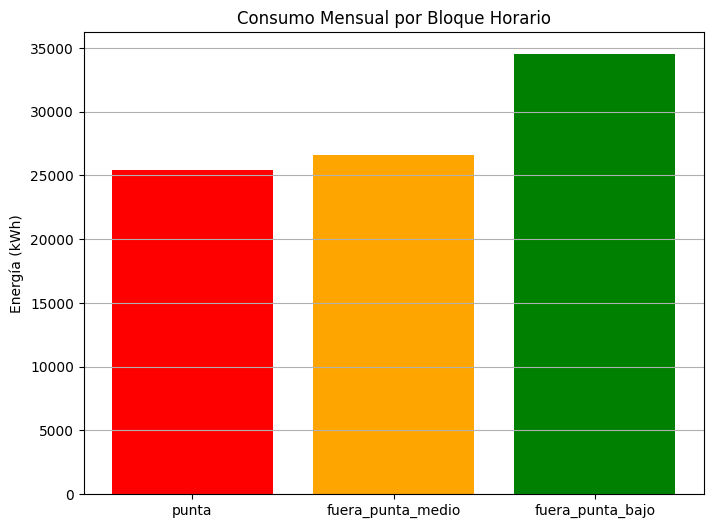

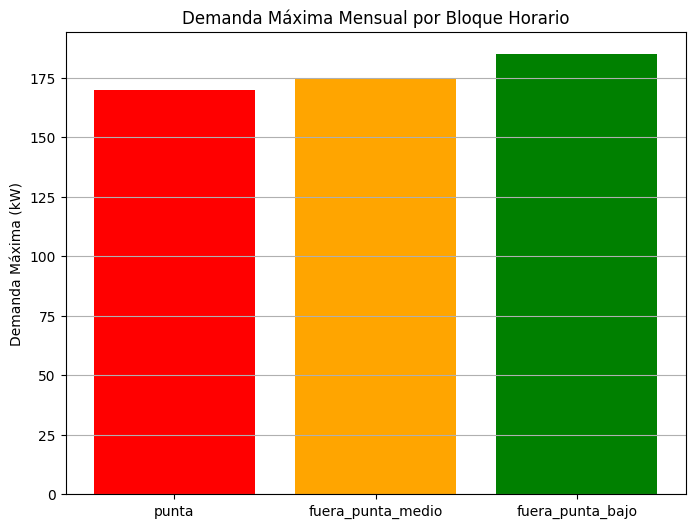

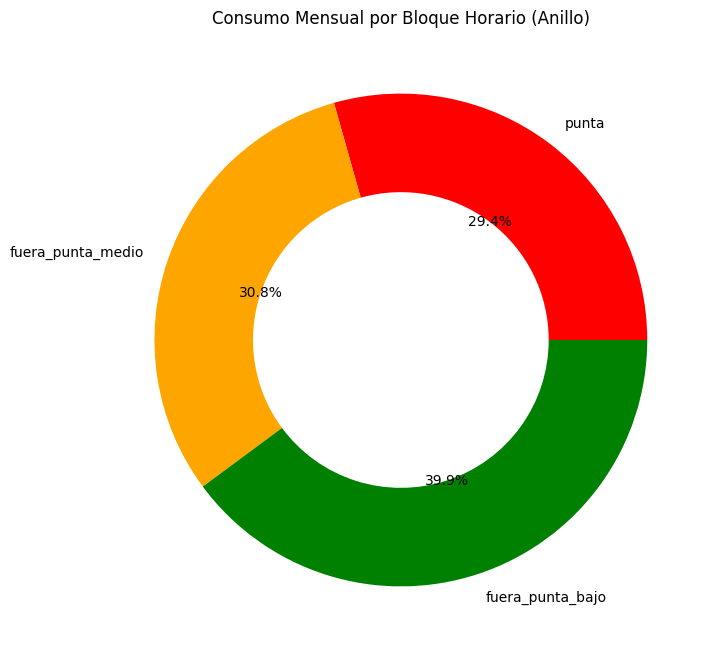

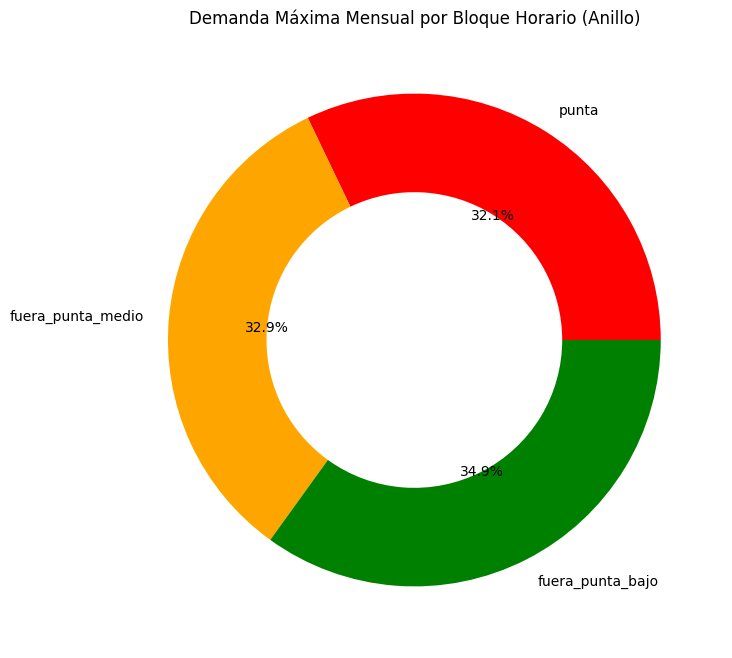

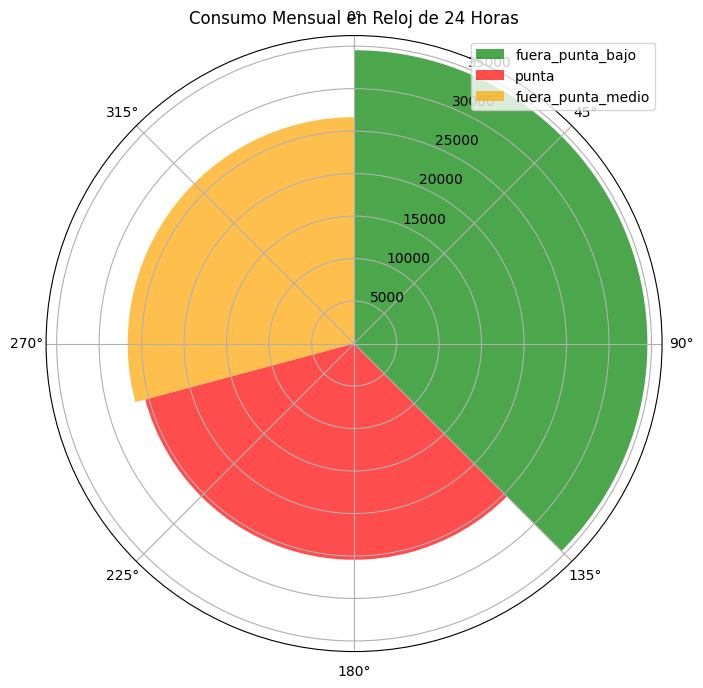

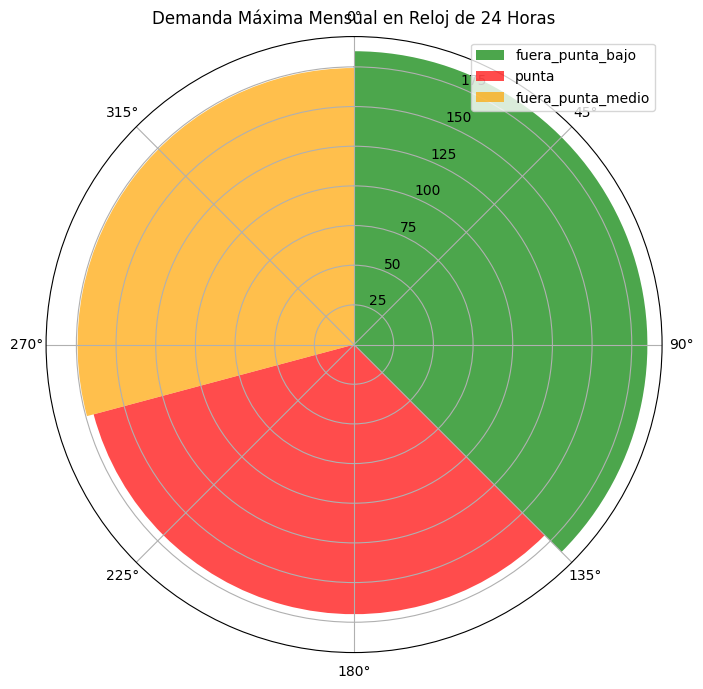


Gráfica de Energía Activa y Reactiva:


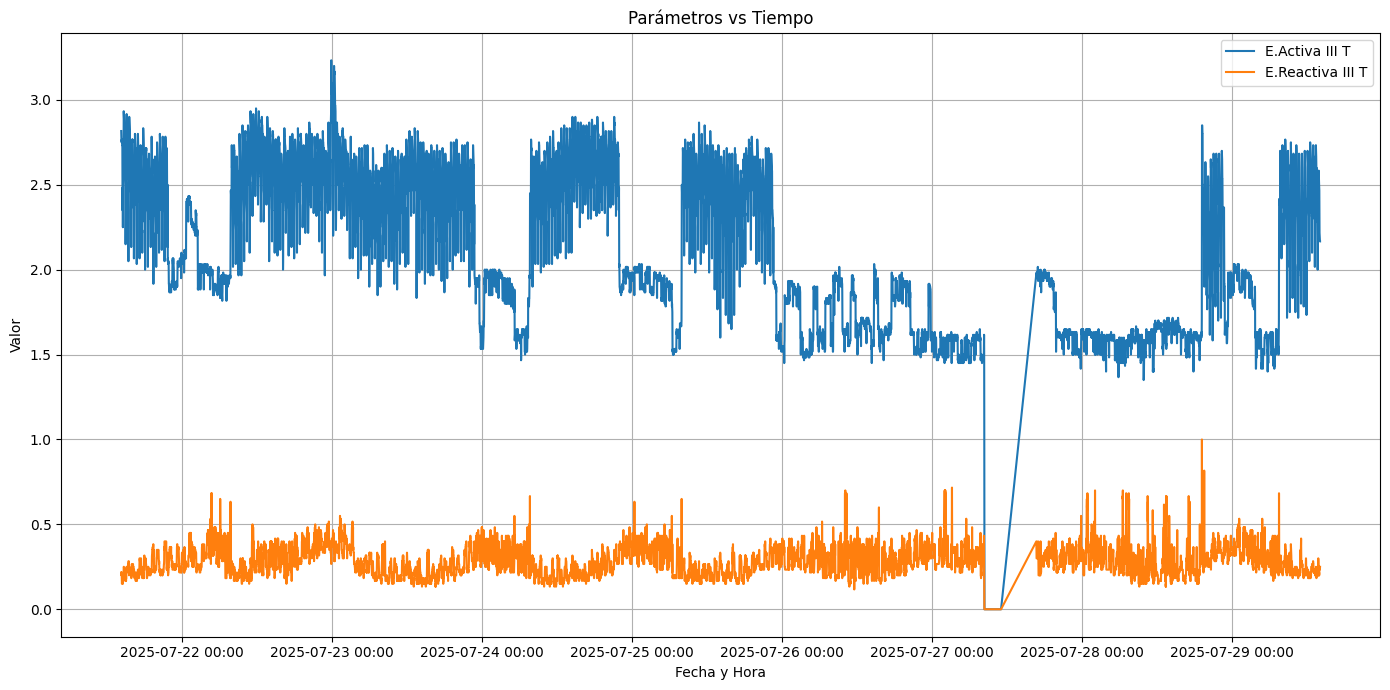


Gráfica de Demanda Máxima (15 minutos):


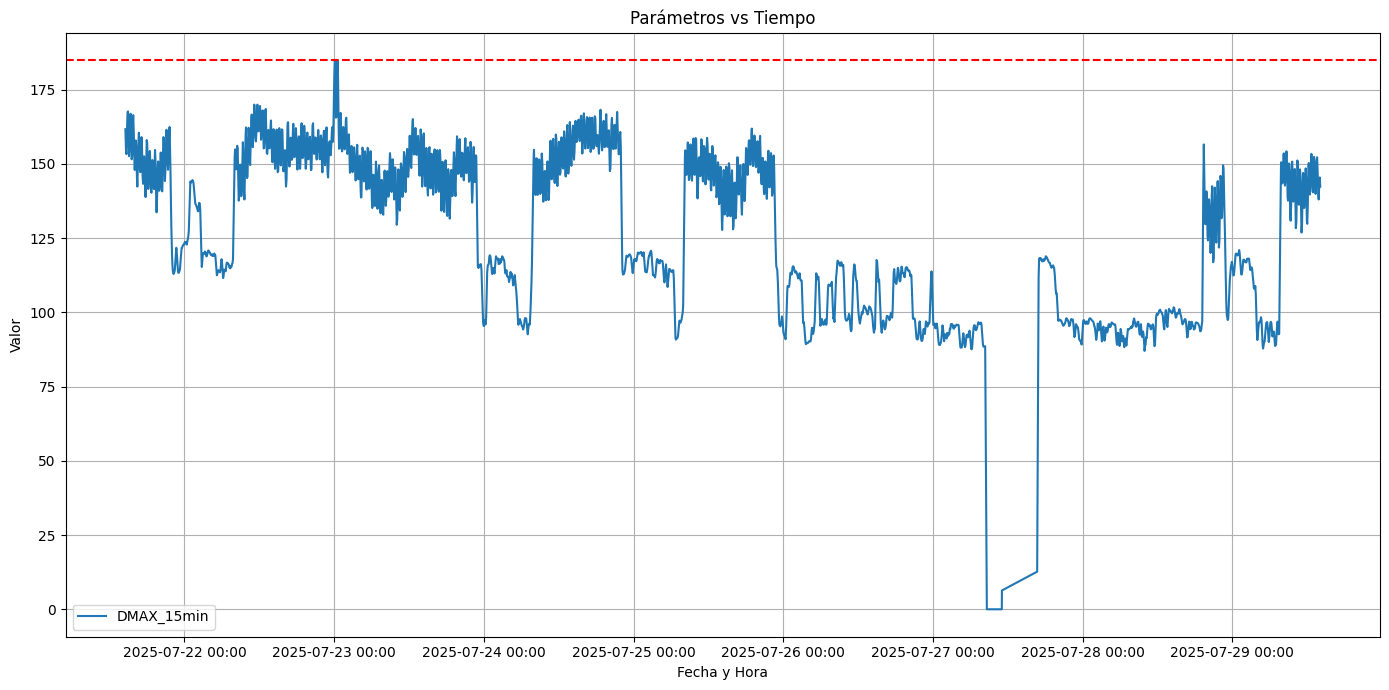



========== PERIODO: 2025-JUL-DIC ==========


--- TARIFA BTS ---
--- BTS ---

=== PERIODO: 2025-JUL-DIC ===

Consumo total: 86605.36 kWh
Cargo Energía: 29750.01 $
Cargo FP: 0.00 $
Cargo Total (sin fijo): 29750.01 $

--- TARIFA BTSH ---
--- BTSH ---

=== PERIODO: 2025-JUL-DIC ===

Consumo total: 86605.36 kWh
Energía Punta: 10850.89 $
Energía Punta Media: 5332.70 $
Energía Punta Bajo: 4052.66 $
Cargo FP: 0.00 $
Cargo Total (sin fijo): 20236.25 $

--- TARIFA BTD ---
--- BTD ---

=== PERIODO: 2025-JUL-DIC ===

Consumo total: 86605.36 kWh
Energía: 15269.24 $
Cargo Demanda: 3442.22 $
Cargo FP: 0.00 $
Cargo Total (sin fijo): 18711.46 $

--- TARIFA BTH ---
--- BTH ---

=== PERIODO: 2025-JUL-DIC ===

Consumo total: 86605.36 kWh
Energía Punta: 7869.88 $
Energía Punta Media: 4507.28 $
Energía Punta Bajo: 3276.31 $
Cargo Demanda: 3763.02 $
Cargo FP: 0.00 $
Cargo Total (sin fijo): 19416.49 $

--- TARIFA MTD ---
--- MTD ---

=== PERIODO: 2025-JUL-DIC ===

Consumo total: 86605.36 kWh
Energía: 14368

In [ ]:
# --- CONFIGURACIÓN ---
nombre_archivo = "h azuero principal.txt"
tipo_energia = 'E.Activa III T'
tipo_demanda = 'DMAX_15min'
tarifas_disponibles = ['BTS', 'BTSH', "BTD", "BTH", "MTD", "MTH"]
periodos_disponibles = ["2025-JUL-DIC"]


# --- CARGA Y PROCESAMIENTO DE DATOS ---
df = cargar_datos(nombre_archivo)
df, df_arm = dividir_dataframe(df)
df_general, df_potencia, df_fasor, df_energia, df_coste, df_secundario = sub_dividir_dataframe(df)
df, fp_mensual = agregar_factor_potencia_mensual(df)
df = procesar_demanda_maxima(df)

# --- ANÁLISIS DE ENERGÍA Y DEMANDA ---
sum_actual, sum_bloque, energia_extrapolada, consumo_bloques_extrapolado = calcular_sumatoria_energia(df, tipo_energia)
dmax_total, dmax_fecha, dmax_bloques = calcular_maxima_demanda_por_bloque(df, tipo_demanda)



# --- VISUALIZACIONES ---
graficar_consumo_por_bloque(consumo_bloques_extrapolado, titulo="Consumo Mensual por Bloque Horario")
graficar_demanda_maxima_por_bloque(dmax_bloques, titulo="Demanda Máxima Mensual por Bloque Horario")

graficar_consumo_anillo(consumo_bloques_extrapolado, titulo="Consumo Mensual por Bloque Horario (Anillo)")
graficar_demanda_maxima_anillo(dmax_bloques, titulo="Demanda Máxima Mensual por Bloque Horario (Anillo)")

graficar_consumo_polar(consumo_bloques_extrapolado, titulo="Consumo Mensual en Reloj de 24 Horas")
graficar_demanda_maxima_polar(dmax_bloques, titulo="Demanda Máxima Mensual en Reloj de 24 Horas")

print("\nGráfica de Energía Activa y Reactiva:")
graficar_parametros(df, ['E.Activa III T', 'E.Reactiva III T'])
print("\nGráfica de Demanda Máxima (15 minutos):")
graficar_parametros(df, [tipo_demanda], lineas_horizontales=[dmax_total])

# --- CÁLCULOS DE TARIFAS ---
# resultados_tarifas = {}

for periodo in periodos_disponibles:
    print(f"\n\n========== PERIODO: {periodo} ==========\n")
    # resultados_tarifas[periodo] = {}

    for tarifa_aplicada in tarifas_disponibles:
        print(f"\n--- TARIFA {tarifa_aplicada} ---")

        if tarifa_aplicada == 'BTS':
            energia, demanda, fp = calcular_BTS(consumo_bloques_extrapolado, fp_mensual, dmax_total, periodo)
        elif tarifa_aplicada == 'BTSH':
            energia, demanda, fp = calcular_BTSH(consumo_bloques_extrapolado, fp_mensual, dmax_total, periodo)
        elif tarifa_aplicada == 'BTD':
            energia, demanda, fp = calcular_BTD(consumo_bloques_extrapolado, fp_mensual, dmax_bloques, periodo)
        elif tarifa_aplicada == 'BTH':
            energia, demanda, fp = calcular_BTH(consumo_bloques_extrapolado, dmax_bloques, fp_mensual, periodo)
        elif tarifa_aplicada == 'MTD':
            energia, demanda, fp = calcular_MTD(consumo_bloques_extrapolado, fp_mensual, dmax_bloques, periodo)
        elif tarifa_aplicada == 'MTH':
            energia, demanda, fp = calcular_MTH(consumo_bloques_extrapolado, dmax_bloques, fp_mensual, periodo)
        else:
            continue

        # resultados_tarifas[periodo][tarifa_aplicada] = {
        #     "energia": energia,
        #     "demanda": demanda,
        #     "fp": fp
        # }


# # --- INFORME FINAL COMPARATIVO ---
# print("\n===== INFORME COMPARATIVO ENTRE TARIFAS =====")
# print(f"Energía mensual real: {sum_actual:.2f} kWh")
# print(f"Energía mensual extrapolada: {energia_extrapolada:.2f} kWh")
# print("\nConsumo por bloques (kWh, extrapolado):")
# for bloque, val in consumo_bloques_extrapolado.items():
#     print(f"  {bloque}: {val:.2f} kWh")

# print(f"\nDemanda máxima mensual (promedio 15min): {dmax_total:.2f} kW")
# print("Demanda máxima por bloque (kW):")
# for bloque, val in dmax_bloques.items():
#     print(f"  {bloque}: {val:.2f} kW")

# print(f"\nFactor de Potencia mensual: {fp_mensual:.4f}")

# print("\n--- COMPARACIÓN DE RESULTADOS POR TARIFA ---")
# for tarifa, valores in resultados_tarifas.items():
#     print(f"\nTARIFA {tarifa}:")
#     print(f"  Cargo por energía: B/. {valores['cargo_energia']:.2f}")
#     print(f"  Cargo por demanda: B/. {valores['cargo_demanda']:.2f}")
#     print(f"  Penalización FP: B/. {valores['cargo_fp']:.2f}")
#     print(f"  TOTAL A PAGAR: B/. {valores['total']:.2f}")


In [ ]:
# --- CONFIGURACIÓN ---
nombre_archivo = "data_dominguez_1m.txt"
# nombre_archivo = "cmsjb_2.csv"

# --- CARGA Y PROCESAMIENTO DE DATOS ---
df = cargar_datos(nombre_archivo)
df, df_arm = dividir_dataframe(df)
df_general, df_potencia, df_fasor, df_energia, df_coste, df_secundario = sub_dividir_dataframe(df)
df_promedios = promediar_df_por_min(df)
print("\nDataFrame con promedios diarios:")
display(df_promedios)



# --- VISUALIZACIONES ---
# fecha_inicial = fecha_final = "2025-06-24"
print("\nGráfica de Potencia Activa y Reactiva:")
# graficar_parametros(df, ['P.Activa III T', 'P.Reactiva III T'],fecha_inicio=fecha_inicial, fecha_fin=fecha_final)
graficar_parametros(df, ['P.Activa III T', 'P.Reactiva III T'], titulo= "Potencias del Sistema Residencia Domínguez")
graficar_parametros(df, [("P.Aparente III T","green")], titulo= "Potencias del Sistema Residencia Domínguez")


No se encontró el archivo 'data_dominguez_1m.txt'. Selecciona uno manualmente:


KeyboardInterrupt: 

In [ ]:
volt_fase = 120

graficar_parametros(df, [('Tensión L1',"red"), ('Tensión L2',"blue")], lineas_horizontales=[(volt_fase, "green"),volt_fase*0.95,volt_fase*1.05], titulo="Voltaje de Fase Residencia Domínguez")


In [ ]:
volt_lin = 240
min_volt = np.min(df["Tensión L12"])
max_volt = np.max(df["Tensión L12"])
print(f"V_min: {min_volt} V")
print(f"V_max: {max_volt} V")
graficar_parametros(df, ["Tensión L12"], lineas_horizontales=[(min_volt, "black"), (max_volt, "black") ,(volt_lin, "green"),volt_lin*0.95,volt_lin*1.05], titulo="Voltaje de Línea Residencia Domínguez")

In [ ]:

graficar_parametros(df, [('P/S',"orange")], lineas_horizontales=[(1, "green"),0.9,-0.9],titulo="Factor de Potencia Instantáneo Residencia Domínguez")

In [ ]:
graficar_parametros(df_promedios, ['Tensión L1', 'Tensión L2'], lineas_horizontales=[(volt_lin, "green"),volt_lin*0.95,volt_lin*1.05])
graficar_parametros(df_promedios, ['Tensión L12'], lineas_horizontales=[(volt_fase, "green"),volt_fase*0.95,volt_fase*1.05])

In [ ]:
graficar_parametros(df, ["Corriente L1", "Corriente L2"], titulo="Corrientes de Fase Residencia Domínguez")
graficar_parametros(df, ["Corriente III"], titulo="Corrientes de Línea Residencia Domínguez")
graficar_parametros(df_promedios,["Corriente III"])

In [ ]:
graficar_parametros(df_promedios, ["Tensión L12"])
graficar_parametros(df_promedios, ["P.Activa III T", "P.Reactiva III T"])

In [ ]:
graficar_parametros(df_promedios, ["Tensión L12"])

In [ ]:
df_sab_dom = promediar_df_por_min(
    df,
    dias_semana=['sábado', 'domingo']
)

df = procesar_demanda_maxima(df)
dmax_prom_total, dmax_hora, dmax_bloq = calcular_maxima_demanda_por_bloque(df, "DMAX_15min")
graficar_parametros(df,["P.Activa III T","DMAX_15min"], lineas_horizontales=[dmax_prom_total],titulo="Demanda Máxima Instantánea Residencia Domínguez")

In [ ]:
df_lun_vie = promediar_df_por_min(
    df,
    dias_semana=['lunes', 'martes', 'miércoles', 'jueves', 'viernes']
)
# display(df_lun_vie.head())
df_lun_vie = procesar_demanda_maxima(df_lun_vie)
dmax_prom_total, dmax_hora, dmax_bloq = calcular_maxima_demanda_por_bloque(df_lun_vie, "DMAX_15min")
graficar_parametros(df_lun_vie,["P.Activa III T","DMAX_15min"], lineas_horizontales=[dmax_prom_total])

In [ ]:
graficar_parametros(df_sab_dom, ["P.Activa III T", "P.Reactiva III T"])
graficar_parametros(df_lun_vie, ["P.Activa III T", "P.Reactiva III T"])

In [ ]:
graficar_parametros(df, ["Tensión L1L2L3"], lineas_horizontales=[(240, "green"),240*0.95,240*1.05], titulo="Tensión de Línea")

In [ ]:
graficar_parametros(df, [("E.Aparente III T","green")], titulo= "Energías del Sistema Residencia Domínguez")